<a href="https://colab.research.google.com/github/Abhi23run/AlgoExpert/blob/main/CodeBase/prompts_transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install be-great
!pip install openpyxl

In [2]:
from be_great import GReaT
import pandas as pd
import torch
import xlrd
from openpyxl import load_workbook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
## Reading in Schema file - Medical Claims
file_path = '/content/drive/MyDrive/Capgemini-Practicum/Dataset/Data Dictionary Medical Claims.xlsx'
df_medical_schema = pd.read_excel(file_path, skiprows=1)

In [21]:
column_indices_to_keep=[3,13,16,18,19,20,21,23,24,25,31,32,33,36,49,52,67,68,75,76,80]
##adjusting for indices
column_indices_to_keep=[i-3 for i in column_indices_to_keep]

In [22]:
df_medical_schema=df_medical_schema.iloc[column_indices_to_keep].reset_index(drop=True)

In [23]:
dtypes = {'_c21': 'str', '_c61': 'str','_c13':'str'}
df_medical_data = pd.read_csv("drive/MyDrive/Capgemini-Practicum/Dataset/medical_claims.csv.gz", usecols=column_indices_to_keep,dtype=dtypes)
print(df_medical_data.shape)

(8092330, 21)


In [24]:
df_medical_data.columns=list(df_medical_schema['Field'])

In [25]:
df_medical_data=df_medical_data[df_medical_data['Member Life ID']!=-1].reset_index(drop=True)

In [26]:
df_medical_data.columns

Index(['Member Life ID', 'Gender Code', 'Subscriber Zip Code',
       'Claim Type Code', 'Claim Number', 'Line #', 'Claim Disposition',
       'Network Indicator', 'Bill Type', 'Internal Provider Number',
       'Place of Service Code', 'Type of Service Code',
       'Current Procedural Terminology', 'Revenue Codes',
       'Primary Diagnosis Code-ICD10', 'ICD10 Surgical Procedure Code 1',
       'Line Service From Date', 'Line Service thru Date', '# of Services',
       'Billed Amount', 'Paid Amount'],
      dtype='object')

In [27]:
df_medical_data['Line Service From Date']=pd.to_datetime(df_medical_data['Line Service From Date'])
df_medical_data['Line Service thru Date']=pd.to_datetime(df_medical_data['Line Service thru Date'])

In [28]:
df_medical_data=df_medical_data[df_medical_data['Line Service From Date'].dt.year==2018][['Member Life ID','Gender Code','Claim Type Code','Claim Number','Line #','Current Procedural Terminology',\
                                                                          'Primary Diagnosis Code-ICD10','Line Service From Date', 'Line Service thru Date','Billed Amount', 'Paid Amount']].reset_index(drop=True)

In [39]:
df_medical_data[df_medical_data['Claim Number']=='801960759500']

,Member Life ID,Gender Code,Claim Type Code,Claim Number,Line #,Current Procedural Terminology,Primary Diagnosis Code-ICD10,Line Service From Date,Line Service thru Date,Billed Amount,Paid Amount
72731,3269408,M,P,801960759500,4,97140,M9904,2018-01-12,2018-01-12,45.0,18.14
81998,3269408,M,P,801960759500,3,97012,M9904,2018-01-12,2018-01-12,55.0,12.15
91067,3269408,M,P,801960759500,1,98943,M9904,2018-01-12,2018-01-12,45.0,0.00
93136,3269408,M,P,801960759500,2,98941,M9904,2018-01-12,2018-01-12,50.0,22.14


In [30]:
df_medical_data[df_medical_data['Member Life ID']==3269408]['Claim Number'].nunique()

52

In [40]:
df_medical_data=df_medical_data.sort_values(by=['Member Life ID','Claim Number', 'Billed Amount'], ascending=[True,True, False]).drop_duplicates(subset='Claim Number', keep='first')[['Member Life ID','Gender Code',\
                                                                                                                                                                                       'Claim Number','Current Procedural Terminology',\
                                                                          'Primary Diagnosis Code-ICD10','Line Service From Date', 'Line Service thru Date','Billed Amount', 'Paid Amount']].reset_index(drop=True)

**plotting the number of claims for each patient**

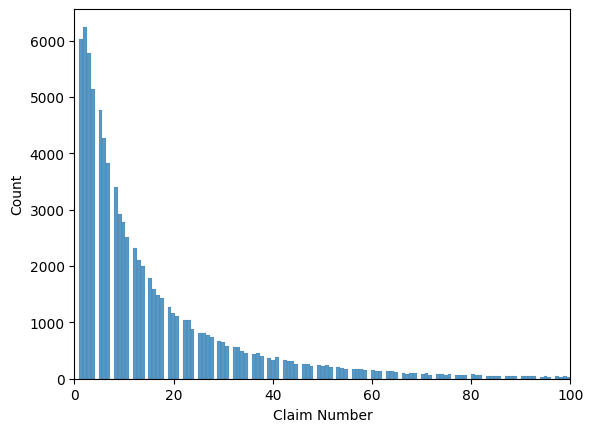

In [58]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.histplot(df_medical_data.groupby(by='Member Life ID',as_index=False)['Claim Number'].nunique()['Claim Number'])
plt.xlim(0, 100)
plt.show()

In [92]:
df_subset=df_medical_data.groupby(by='Member Life ID',as_index=False)['Claim Number'].nunique().rename(columns={'Claim Number':'num_unique_claims'})
member_id_to_keep=list(df_subset[df_subset['num_unique_claims']<=5]['Member Life ID'].unique())
df_medical_data_subset=df_medical_data[df_medical_data['Member Life ID'].isin(member_id_to_keep)].reset_index(drop=True)

In [93]:
df_medical_data_subset['Patient ID']=df_medical_data_subset['Member Life ID'].map(dict(zip(df_medical_data_subset['Member Life ID'].unique(),range((df_medical_data_subset['Member Life ID'].nunique())))))

In [96]:
df_medical_data_subset[df_medical_data_subset['Member Life ID']==470]

,Member Life ID,Gender Code,Claim Number,Current Procedural Terminology,Primary Diagnosis Code-ICD10,Line Service From Date,Line Service thru Date,Billed Amount,Paid Amount,Patient ID
2,470,M,805812602600,T2022,R6889,2018-01-31,2018-01-31,395.0,395.00,1
3,470,M,808817770600,T2023,F322,2018-01-12,2018-01-12,390.0,390.00,1
4,470,M,813715164300,99214,F331,2018-05-16,2018-05-16,256.0,169.77,1


In [100]:
df_medical_data_subset.columns=[x.replace(' ','_').lower() for x in df_medical_data_subset.columns]

In [105]:
patient_data=df_medical_data_subset[df_medical_data_subset['member_life_id']==470]

In [104]:
for patient_id in list(df_medical_data_subset["patient_id"].unique()):
  patient_data=df_medical_data_subset[df_medical_data_subset['patient_id']==patient_id]

array([    0,     1,     2, ..., 27970, 27971, 27972])

In [108]:
range(patient_data.shape[0])

range(0, 3)

In [123]:
df_medical_data_subset

,member_life_id,gender_code,claim_number,current_procedural_terminology,primary_diagnosis_code-icd10,line_service_from_date,line_service_thru_date,billed_amount,paid_amount,patient_id
0,234,M,026183037253100,80061,I10,2018-10-19,2018-10-19,49.59,13.28,0
1,234,M,026183131807000,90750,Z23,2018-10-19,2018-10-19,318.00,142.80,0
2,470,M,805812602600,T2022,R6889,2018-01-31,2018-01-31,395.00,395.00,1
3,470,M,808817770600,T2023,F322,2018-01-12,2018-01-12,390.00,390.00,1
4,470,M,813715164300,99214,F331,2018-05-16,2018-05-16,256.00,169.77,1
...,...,...,...,...,...,...,...,...,...,...
80303,38511568,M,026190084563300,99381,Z00110,2018-12-28,2018-12-28,270.00,208.89,27970
80304,38541263,M,831919010100,99393,Z00129,2018-11-12,2018-11-12,175.00,68.07,27971
80305,38541263,M,832414390100,99202,L309,2018-11-16,2018-11-16,147.00,84.50,27971
80306,38752147,M,833215989300,92014,H4052X3,2018-11-21,2018-11-21,260.00,0.00,27972


In [124]:
df_medical_data_subset=df_medical_data_subset[['member_life_id','gender_code', 'claim_number',
       'current_procedural_terminology', 'primary_diagnosis_code-icd10',
       'line_service_from_date', 'line_service_thru_date', 'billed_amount',
       'paid_amount']].rename(columns={'member_life_id':'patient_id','current_procedural_terminology':'cpt_code','primary_diagnosis_code-icd10':'primary_diagnosis_code','line_service_from_date':'visit_start_date','line_service_thru_date':'visit_end_date'})

In [126]:
df_medical_data_subset

,patient_id,gender_code,claim_number,cpt_code,primary_diagnosis_code,visit_start_date,visit_end_date,billed_amount,paid_amount
0,234,M,026183037253100,80061,I10,2018-10-19,2018-10-19,49.59,13.28
1,234,M,026183131807000,90750,Z23,2018-10-19,2018-10-19,318.00,142.80
2,470,M,805812602600,T2022,R6889,2018-01-31,2018-01-31,395.00,395.00
3,470,M,808817770600,T2023,F322,2018-01-12,2018-01-12,390.00,390.00
4,470,M,813715164300,99214,F331,2018-05-16,2018-05-16,256.00,169.77
...,...,...,...,...,...,...,...,...,...
80303,38511568,M,026190084563300,99381,Z00110,2018-12-28,2018-12-28,270.00,208.89
80304,38541263,M,831919010100,99393,Z00129,2018-11-12,2018-11-12,175.00,68.07
80305,38541263,M,832414390100,99202,L309,2018-11-16,2018-11-16,147.00,84.50
80306,38752147,M,833215989300,92014,H4052X3,2018-11-21,2018-11-21,260.00,0.00


In [127]:
import pandas as pd

# Assuming we have a dataframe 'df' with the necessary columns.
# The function to be applied across the dataframe would look something like this:

def format_visit_information(row):
    # Extract the column names except 'patient_id' and 'gender_code'
    column_names = row.index.tolist()
    column_names.remove('patient_id')
    column_names.remove('gender_code')

    # Build the visit information string with column names and values
    visit_info = ", ".join(f"{col} as {row[col]}" for col in column_names)
    return f"{visit_info}"

# Applying the function to each row of the DataFrame and assigning the result to a new 'visit_info' column
# df['visit_info'] = df.apply(format_visit_information, axis=1)

# Now, assuming the dataframe contains multiple patients and we want to group by 'patient_id' and 'gender_code'
# and then apply the visit information formatting to each group.

# Modified function to concatenate visit information with each visit on a new line
def concatenate_visits(group):
    visit_details = group.apply(format_visit_information, axis=1).tolist()
    return "\n".join(f"<visit_{i+1}> : {details}" for i, details in enumerate(visit_details))

# Group by 'patient_id' and 'gender_code' and apply the concatenation function
# grouped_info = df.groupby(['patient_id', 'gender_code']).apply(concatenate_visits).reset_index(name='visit_info')

# The 'grouped_info' DataFrame will now have a summary string for each patient.

In [128]:
grouped_info = df_medical_data_subset.groupby(['patient_id', 'gender_code']).apply(concatenate_visits).reset_index(name='visit_info')

grouped_info

,patient_id,gender_code,visit_info
0,234,M,"<visit_1> : claim_number as 026183037253100, c..."
1,470,M,"<visit_1> : claim_number as 805812602600, cpt_..."
2,495,M,"<visit_1> : claim_number as 020182880162900, c..."
3,944,M,"<visit_1> : claim_number as 026183470738300, c..."
4,1305,F,"<visit_1> : claim_number as 822970727300, cpt_..."
...,...,...,...
27980,38503401,F,"<visit_1> : claim_number as 8249K0294300, cpt_..."
27981,38509136,F,"<visit_1> : claim_number as 026181214463400, c..."
27982,38511568,M,"<visit_1> : claim_number as 020190020496500, c..."
27983,38541263,M,"<visit_1> : claim_number as 831919010100, cpt_..."


In [129]:
grouped_info.to_csv('drive/MyDrive/Capgemini-Practicum/Dataset/patient_visit_info.csv')

In [130]:
print(grouped_info.loc[0,'visit_info'])

<visit_1> : claim_number as 026183037253100, cpt_code as 80061, primary_diagnosis_code as I10, visit_start_date as 2018-10-19 00:00:00, visit_end_date as 2018-10-19 00:00:00, billed_amount as 49.59, paid_amount as 13.28
<visit_2> : claim_number as 026183131807000, cpt_code as 90750, primary_diagnosis_code as Z23, visit_start_date as 2018-10-19 00:00:00, visit_end_date as 2018-10-19 00:00:00, billed_amount as 318.0, paid_amount as 142.8
